GT4Py - GridTools Framework

Copyright (c) 2014-2024, ETH Zurich
All rights reserved.

Please, refer to the LICENSE file in the root directory.
SPDX-License-Identifier: BSD-3-Clause


## Horizontal Diffusion Example

### Imports and utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gt4py.storage
import gt4py.cartesian.gtscript as gtscript

### Global definitions

In [2]:
backend = (
    "numpy"  # options: "numpy", "gt:cpu_ifirst", "gt:cpu_kfirst", "gt:gpu", "dace:cpu", "dace:gpu"
)
dtype = np.float64

### Define GTScript stencil

In [3]:
@gtscript.stencil(backend)  # this decorator triggers compilation of the stencil
def horizontal_diffusion(
    in_field: gtscript.Field[dtype],
    out_field: gtscript.Field[dtype],
    coeff: gtscript.Field[dtype],
):
    with computation(PARALLEL), interval(...):
        lap_field = 4.0 * in_field[0, 0, 0] - (
            in_field[1, 0, 0] + in_field[-1, 0, 0] + in_field[0, 1, 0] + in_field[0, -1, 0]
        )
        res = lap_field[1, 0, 0] - lap_field[0, 0, 0]
        flx_field = 0 if (res * (in_field[1, 0, 0] - in_field[0, 0, 0])) > 0 else res
        res = lap_field[0, 1, 0] - lap_field[0, 0, 0]
        fly_field = 0 if (res * (in_field[0, 1, 0] - in_field[0, 0, 0])) > 0 else res
        out_field = in_field[0, 0, 0] - coeff[0, 0, 0] * (
            flx_field[0, 0, 0] - flx_field[-1, 0, 0] + fly_field[0, 0, 0] - fly_field[0, -1, 0]
        )

### Initialize Fields

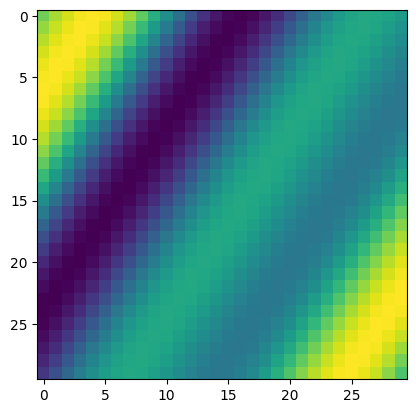

In [4]:
# Initialize example data
N = 30
shape = (N, N, N)
origin = (2, 2, 0)

indices = np.arange(N)
ii = np.zeros((N, N, N)) + np.reshape(indices, (N, 1, 1))
jj = np.zeros((N, N, N)) + np.reshape(indices, (1, N, 1))
kk = np.zeros((N, N, N)) + np.reshape(indices, (1, 1, N))

xx = ii / N
yy = jj / N
zz = kk / N

in_data = (
    5.0 + 8.0 * (2.0 + np.cos(np.pi * (xx + 1.5 * yy)) + np.sin(2 * np.pi * (xx + 1.5 * yy))) / 4.0
)
out_data = np.zeros(shape)
coeff_data = 0.025 * np.ones(shape)

# Plot initialization
projection = np.array(np.sum(in_data, axis=2))
plt.imshow(projection)

### Copy input data from numpy arrays to gt4py storages


In [5]:
in_storage = gt4py.storage.from_array(in_data, dtype, backend=backend, aligned_index=origin)
out_storage = gt4py.storage.from_array(out_data, dtype, backend=backend, aligned_index=origin)
coeff_storage = gt4py.storage.from_array(coeff_data, dtype, backend=backend, aligned_index=origin)

### Run computation

In [6]:
horizontal_diffusion(in_storage, out_storage, coeff_storage, origin=origin)

### Plot results

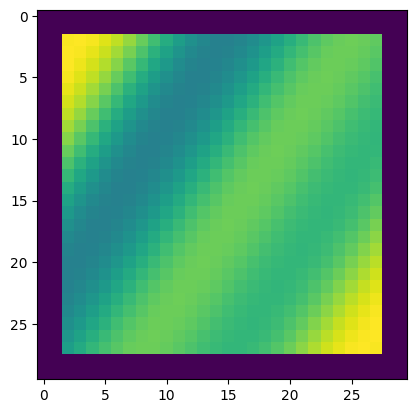

In [7]:
projection = np.asarray(np.sum(out_storage, axis=2))
plt.imshow(projection)